In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [30]:
# Read in data
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/ML_Learning/CSV /ramen-ratings.csv', encoding = "utf-8")
print(df.shape)
df = df.head(500)
print(df.shape)

(2580, 7)
(500, 7)


In [31]:
df.head()

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
0,2580,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,NaN
1,2579,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1,NaN
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,NaN
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,NaN
4,2576,Ching's Secret,Singapore Curry,Pack,India,3.75,NaN


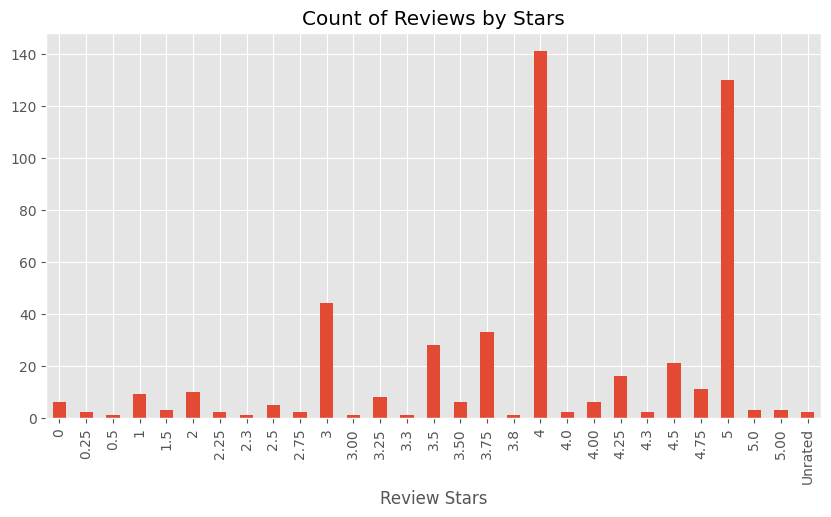

In [32]:
ax = df['Stars'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

# **basic using NLTK**

In [ ]:
example = df['Text'][50]
print(example)

In [ ]:
tokens = nltk.word_tokenize(example)
tokens[:10]

# ['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [ ]:
tagged = nltk.pos_tag(tokens)
tagged[:10]


# [('This', 'DT'),
#  ('oatmeal', 'NN'),
#  ('is', 'VBZ'),
#  ('not', 'RB'),
#  ('good', 'JJ'),
#  ('.', '.'),
#  ('Its', 'PRP$'),
#  ('mushy', 'NN'),
#  (',', ','),
#  ('soft', 'JJ')]

In [ ]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()
# (S
#   This/DT
#   oatmeal/NN
#   is/VBZ
#   not/RB
#   good/JJ
#   ./.
#   Its/PRP$
#   mushy/NN
#   ,/,
#   soft/JJ
#   ,/,
#   I/PRP
#   do/VBP
#   n't/RB
#   like/VB
#   it/PRP
#   ./.
#   (ORGANIZATION Quaker/NNP Oats/NNPS)
#   is/VBZ
#   the/DT
#   way/NN
#   to/TO
#   go/VB
#   ./.)

##using vader

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

sia.polarity_scores('I am so happy!')
#{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [ ]:
sia.polarity_scores('This is the worst thing ever.')
# {'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [ ]:
sia.polarity_scores(example)
# {'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [ ]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)


# 100%
# 500/500 [00:00<00:00, 901.30it/s]

In [ ]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')
# Now we have sentiment score and metadata
vaders.head()

##plot vader result

In [ ]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

##roberta pretrained model


In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
# Downloading: 100%
# 747/747 [00:00<00:00, 23.7kB/s]
# Downloading: 100%
# 878k/878k [00:00<00:00, 2.29MB/s]
# Downloading: 100%
# 446k/446k [00:00<00:00, 818kB/s]
# Downloading: 100%
# 150/150 [00:00<00:00, 5.03kB/s]
# Downloading: 100%
# 476M/476M [00:22<00:00, 23.4MB/s]
# VADER results on example
print(example)
sia.polarity_scores(example)
# This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.
# {'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)
# {'roberta_neg': 0.9763551, 'roberta_neu': 0.020687457, 'roberta_pos': 0.0029573673}
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')
# 100%
# 500/500 [01:42<00:00, 3.62it/s]
# Broke for id 83
# Broke for id 187
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

In [ ]:
#compare score between model
results_df.columns

##Combine and compare plot

In [ ]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()